# <center>Virality Prediction via Graph Neural Networks</center>
---

# Setup

## Check GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-3d3d6c30-991e-08eb-f4dc-bbc3965d5089)


## Google Drive

In [ ]:
from google.colab import drive
GDRIVE_HOME = '/content/drive'

drive.mount(GDRIVE_HOME, force_remount=True)

Mounted at /content/drive


## Installation

### Pytorch

In [ ]:
!pip install torch

In [ ]:
import torch

TORCH_VERSION = torch.__version__[:5]
CUDA_VERSION = torch.version.cuda.replace('.','')
print(f'Running torch version {TORCH_VERSION}, with CUDA version {CUDA_VERSION}')

Running torch version 1.6.0, with CUDA version 101


### Pytorch-geometric

In [ ]:
!pip install torch-scatter==latest+cu{CUDA_VERSION} -f https://pytorch-geometric.com/whl/torch-{TORCH_VERSION}.html
!pip install torch-sparse==latest+cu{CUDA_VERSION} -f https://pytorch-geometric.com/whl/torch-{TORCH_VERSION}.html
!pip install torch-cluster==latest+cu{CUDA_VERSION} -f https://pytorch-geometric.com/whl/torch-{TORCH_VERSION}.html
!pip install torch-spline-conv==latest+cu{CUDA_VERSION} -f https://pytorch-geometric.com/whl/torch-{TORCH_VERSION}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.6.0/torch_scatter-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-scatter 2.0.5
    Uninstalling torch-scatter-2.0.5:
      Successfully uninstalled torch-scatter-2.0.5
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.6.0/torch_sparse-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-sparse 0.6.7
    Uninstalling torch-sparse-0.6.7:
      Successfully uninstalled torch-sparse-0.6.7
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.6.0/torch_cluster-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-cluster 1.5.7
    Uninstalling torch-cluster-1.5.7:
      Successfully uninstalled torch-cluster-1.5.7
Looking in links: https

### Lightning

In [ ]:
!pip install pytorch-lightning==0.9.1rc1

## Imports

In [ ]:
# deep learning
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim
import numpy as np
torch.set_printoptions(threshold=10000)

## pytorch geometric
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset, DataLoader
from torch_geometric.utils import dropout_adj
from torch_geometric.utils.convert import from_networkx
import torch_geometric.transforms as T 
from torch_sparse import SparseTensor, set_diag
from pytorch_lightning.loggers import TensorBoardLogger
# from torch_scatter import scatter
# import torch_geometric.nn.pool as pool

## lightning
import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning import Callback
import pytorch_lightning.metrics as pl_metrics 

# graphs
import networkx as nx

# misc
import os
import math
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import *
import json
from typing import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Configuration

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
CONFIG = {
    "use_model": "GCN", # "GAT", 
    "loss": "cross-entropy", # "mrse",
    "use_data": "synth", # "real"
    "train_target": "node",
    "test_target": "graph",
    "hidden_dim": 64,
    "dropout": 0.2,
    "num_layers": 4,
    "lr": 1e-3,
    "num_epochs": 20,
    "early_stopping": True,
    "min_delta": 0.0,
    "patience": 5,
}

In [ ]:
PROJECT_HOME = os.path.join(GDRIVE_HOME, 'My Drive/DL/Project')
folder_name = CONFIG["use_data"]
data_folder = os.path.join(PROJECT_HOME, f'data/{folder_name}')


In [ ]:
model_name = f"{CONFIG['use_model']}-{CONFIG['loss']}-{CONFIG['use_data']}"

In [ ]:
save_folder = os.path.join(PROJECT_HOME, 'SavedModel')
save_folder_model = os.path.join(save_folder, model_name)

if not os.path.exists(save_folder_model):
    os.makedirs(save_folder_model)

savedmodel_path = os.path.join(save_folder_model, "weights.pt")

# resume_from_checkpoint = False # checkpoint_path

### Reproducibility

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Problem formalization

Given a piece of information $m$, we define its *cascade* as the set of adopters of the information. In particular, the *observed cascade* is the set of *early adopters* within observation time $T$:
$$
\mathcal{C}_{T}^{m} = \{ u_1, u_2, \dots, u_{n_T^m} \}
$$
where 
$$
n_{T}^{m} = \text{number of early adopters of information } m 
$$

Node feature (observable data):
$$
s_{v}^{(0)} = \text{initial activation state of node } v
$$

Node labels (to predict):
$$
s_{v}^{(K)} = \text{final activation state of node } v
$$

Node representation (to be learned):
$$
\mathbf{r}_{v}^{(i)} = \text{representation of node } v \text{ from network structure and state } s_{v}^{(i)}
$$

Final label for the piece of information $m$:
$$
\mathcal{P}_{m} = \sum_{v \in \mathcal{V}} s_{v}^{(K)} = n_{\infty}^m
$$

# Data handling

## Data loading

In [ ]:
graph_path = os.path.join(data_folder, 'graph.gexf')
G = nx.read_gexf(graph_path)
num_nodes = G.number_of_nodes()

In [ ]:
cascades_path = os.path.join(data_folder, 'cascades.json')

with open(cascades_path, 'r') as f:
    cascades = json.load(f)


In [ ]:
edge_index = torch.Tensor([[int(tup[0]), int(tup[1])] for tup in list(G.edges)]).long()
edge_index = edge_index.transpose(0, 1).contiguous().view(2, -1)

data = {'edge_index': edge_index}

for node_id, feat_dict in G.nodes(data=True):
    for key, value in feat_dict.items():
        data[key] = data.get(key, []) + [value]

graph = Data.from_dict(data)

graph.num_nodes = G.number_of_nodes()

In [ ]:
samples = []

for hashtag, cascade in tqdm(cascades.items()):
    early_adopt = cascade['early']
    final_adopt = cascade['final']

    x = torch.zeros(num_nodes)
    x[early_adopt] = 1
    x = x.unsqueeze(-1).float()

    y = torch.zeros(num_nodes)
    y[final_adopt] = 1
    y = y.long()

    sample = {'x': x, 'y': y}
    samples.append(sample)

## Data preprocessing

### Train-dev-test Splitting

In [ ]:
random.shuffle(samples)
num_samples = len(samples)

TRAIN_RATIO = 0.7
DEV_RATIO = 0.2
TEST_RATIO = 0.1

train_ub = int(math.floor(num_samples*TRAIN_RATIO))
val_ub = train_ub + int(math.floor(num_samples*DEV_RATIO))

train_set = samples[0: train_ub]
val_set = samples[train_ub: val_ub]
test_set = samples[val_ub:]

## Dataset building

In [ ]:
class GraphDataset(Dataset):
    def __init__(self, graph, samples, target):
        """
            graph: the fixed graph encoding the underlying structure
            features: list (num_samples) containing tensors (num_nodes, feature_dim)
            labels: list (num_samples) containing tensors (num_nodes, feature_dim)
        """
        self.graph = graph 
        self.feature_names = self.get_feature_names()
        self.static_features = self.get_static_features()
        self.samples = samples
        self.target = target


    def __getitem__(self, idx):
        x = self.samples[idx]['x']
        y = self.samples[idx]['y']
        edge_index = self.graph.edge_index
        static_features = self.static_features
        
        # Popularity of hashtag
        if self.target == 'graph':
            y = torch.sum(y, dim=-1)
        elif self.target == 'node':
            pass
        else:
            raise NotImplementedError

        return {'x': x, 'y': y, 'edge_index': edge_index, 'static_features': static_features}

    def get_static_features(self):
        static_features = torch.stack([torch.tensor(self.graph[static_feature]) for static_feature in self.feature_names ], dim=1)
        return static_features

    def get_feature_names(self):
        features = graph.keys
        features.remove('label')
        features.remove('edge_index')
        return features

    def __len__(self):
        return len(self.samples)

In [ ]:
train_dataset = GraphDataset(graph, train_set, CONFIG["train_target"])
val_dataset = GraphDataset(graph, val_set, CONFIG["train_target"])

## Collate and Data loaders

In [ ]:
BATCH_SIZE = 16

def graph_collate(batch): 
    
    data_list = []
    for sample in batch:
        
        edge_index = sample['edge_index']
        x = sample['x']
        static_features = sample['static_features']

        x = torch.cat((x, static_features), dim=1)
        
        y = sample['y']

        data_list.append(Data(x=x, edge_index=edge_index, y=y))
    
    return Batch.from_data_list(data_list)

In [ ]:
train_loader = DataLoader(train_dataset, collate_fn=graph_collate, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, collate_fn=graph_collate, batch_size=BATCH_SIZE)

# Model definition

## Sum pooling

In [ ]:
class SumPooling(nn.Module):
    def __init__(self):
        super().__init__()
        self._summing_matrix = None

    def forward(self, x, batch):
        """
        Args:
            data: a batch of graphs
        """
        batch_size = torch.max(batch) + 1
        num_nodes = x.shape[0] // batch_size

        sum_pool = torch.zeros((batch_size,), dtype=x.dtype, device=x.device)
        
        for i in range(batch_size):
            x_graph = x[i*num_nodes:(i+1)*num_nodes, ...]
            sum_pool[i] = torch.sum(x_graph)

        return sum_pool

## Network

In [ ]:
class Net(nn.Module):
    def __init__(self, num_node_features, num_layers, 
                 hidden_dim, dropout, graph_prediction):
        
        super().__init__()
        
        self.convs = torch.nn.ModuleList()
        self.p_dropout = dropout
        self.dropout = nn.Dropout(dropout)
        self.edge_dropout = dropout_adj

        self.graph_prediction = graph_prediction

        self.sum_pooling = SumPooling()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Convolutions
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = self.dropout(x)
            edge_index, _ = self.edge_dropout(edge_index, p=self.p_dropout)
        
        # Last convolution + sigmoid computes nodes 'activation state'
        x = self.convs[-1](x, edge_index)
        
        if self.graph_prediction:
            x = torch.sigmoid(x)
            
            # Sum pooling over the nodes computes the spread of the information
            x = self.sum_pooling(x, batch)
        return x

### GCN

In [ ]:
class GCNNet(Net):
    def __init__(self, num_node_features, num_layers, 
                 hidden_dim, dropout, graph_prediction):
        
        super().__init__(
            num_node_features, num_layers, 
            hidden_dim, dropout, graph_prediction
        )
        
        self.convs.append(
            GCNConv(num_node_features, hidden_dim, normalize=True)
        )
        
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_dim, hidden_dim, normalize=True)
            )
        
        # If graph prediction, then output a popularity for the whole graph, 
        # otherwise, output logits for binary classification
        out_dim = 1 if self.graph_prediction else 2
        self.convs.append(
            GCNConv(hidden_dim, out_dim, normalize=True)
        )

### GAT

In [ ]:
class GATNet(Net):
    def __init__(self, num_node_features, num_layers, 
                 hidden_dim, dropout, graph_prediction):
                
        super().__init__(
            num_node_features, num_layers, 
            hidden_dim, dropout, graph_prediction
        )

        self.convs.append(
            GATConv(num_node_features, hidden_dim)
        )
        
        for _ in range(num_layers - 2):
            self.convs.append(
                GATConv(hidden_dim, hidden_dim)
            )
        
        # If graph prediction, then output a popularity for the whole graph, 
        # otherwise, output logits for binary classification
        out_dim = 1 if self.graph_prediction else 2
        self.convs.append(
            GATConv(hidden_dim, out_dim)
        )

## Loss function

In [ ]:
class MRSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_pred, y_true):
        """
        Returns the Mean Relative Squared Error, defined as
            L_MRSE = 1/M \sum_{m = 1}^{M} [( \hat{y}_m - y_m )/y_m]^2
        """
        relative_error = (y_pred - y_true) / y_true
        rse = torch.pow(relative_error, 2)
        mrse = torch.mean(rse, dim=-1)

        return mrse

## Lightning module

In [ ]:
class LitModule(pl.LightningModule):
    
    def __init__(self, model, 
                 loss_fn=None, 
                 val_metric=None):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.val_metric = val_metric
    
    def forward(self, data):
        return self.model(data)

    def training_step(self, batch, batch_idx):
        assert self.loss_fn is not None

        y_train_true = batch['y']

        output = self(batch)
        
        loss = self.loss_fn(output, y_train_true)
        
        result = pl.TrainResult(minimize=loss)
        result.log('train_loss', loss)

        return result

    def predict(self, output):
        if self.model.graph_prediction:
            y_pred = torch.round(output)
        else:
            logits_softmaxed = F.softmax(output, dim=-1)
            y_pred = torch.argmax(logits_softmaxed, dim=-1)
        
        return y_pred

    def validation_step(self, batch, batch_idx):
        assert self.loss_fn is not None

        y_val_true = batch['y']
        output = self(batch)

        val_loss = self.loss_fn(output, y_val_true)

        if self.val_metric is not None:
            y_val_pred = self.predict(output)
            val_metric = self.val_metric(y_val_pred, y_val_true)
            log_dict = {'val_loss': val_loss, 'val_metric': val_metric}
        else:
            val_metric = val_loss
            log_dict = {'val_loss': val_loss}

        result = pl.EvalResult(early_stop_on=val_metric)
        result.log_dict(
            log_dict, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return result

    def test_step(self, batch, batch_idx):
        assert self.loss_fn is not None
        
        y_test_true = batch['y']

        output = self(batch) 

        test_loss = self.loss_fn(output, y_test_true)

        if self.val_metric is not None:
            y_test_pred = self.predict(output)
            test_metric = self.val_metric(y_test_pred, y_test_true)
            log_dict = {'test_loss': test_loss, 'test_metric': test_metric}
        else:
            val_metric = val_loss
            log_dict = {'test_loss': test_loss}

        result = pl.EvalResult()
        result.log_dict(
            log_dict, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return result

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=CONFIG["lr"])

# Model instantiation

## Loss function and metrics

In [ ]:
if CONFIG["loss"] == "mrse":
    loss_fn = MRSELoss()
    val_metric = None
    graph_prediction = True
elif CONFIG["loss"] == "cross-entropy":
    loss_fn = nn.CrossEntropyLoss()
    val_metric = pl_metrics.classification.F1()
    graph_prediction = False
else:
    raise NotImplementedError

## Model building

In [ ]:

if CONFIG["use_model"] == "GCN":
    model = GCNNet(num_node_features=6,
                num_layers=CONFIG["num_layers"],
                hidden_dim=CONFIG["hidden_dim"],
                dropout=CONFIG["dropout"],
                graph_prediction=graph_prediction)
elif CONFIG["use_model"] == "GAT":
    model = GATNet(num_node_features=6,
                num_layers=CONFIG["num_layers"],
                hidden_dim=CONFIG["hidden_dim"],
                dropout=CONFIG["dropout"],
                graph_prediction=graph_prediction)
else:
    raise NotImplementedError

In [ ]:
model = model.to(device)

In [ ]:
lit_model = LitModule(model, loss_fn, val_metric)

# Training

## Callbacks

In [ ]:
early_stop_callback = EarlyStopping(
   min_delta=CONFIG["min_delta"],
   patience=CONFIG["patience"],
   verbose=True,
   mode='max'
)

In [ ]:
# Clear logs folder
!rm -rf "./tb_logs"

In [ ]:
logger = TensorBoardLogger('tb_logs', name=model_name)

## Train loop

In [ ]:
trainer = Trainer(
    gpus=1, 
    max_epochs=CONFIG["num_epochs"], 
    num_sanity_val_steps=0, 
    logger=logger,
    early_stop_callback=early_stop_callback if CONFIG["early_stopping"] else None,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(lit_model, train_dataloader=train_loader, val_dataloaders=val_loader)


  | Name       | Type             | Params
------------------------------------------------
0 | model      | GCNNet           | 8 K   
1 | loss_fn    | CrossEntropyLoss | 0     
2 | val_metric | F1               | 0     


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: The metric you returned None must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of loss in validation_epoch_end()?
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: Can save best model only with loss available, skipping.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..
Epoch 00007: early stopping triggered.


1

## Save model

In [ ]:
torch.save(model.state_dict(), savedmodel_path)

# Evaluation

## Load model

### Model

In [ ]:
if CONFIG["loss"] == "mrse":
    loss_fn = MRSELoss()
    val_metric = None
    graph_prediction = True
    test_dataset = GraphDataset(graph, test_set, "graph")
    test_loader = DataLoader(test_dataset, collate_fn=graph_collate, batch_size=BATCH_SIZE)
elif CONFIG["loss"] == "cross-entropy":
    loss_fn = nn.CrossEntropyLoss()
    val_metric = pl_metrics.classification.F1()
    graph_prediction = False
    test_dataset = GraphDataset(graph, test_set, "node")
    test_loader = DataLoader(test_dataset, collate_fn=graph_collate, batch_size=BATCH_SIZE)
else:
    raise NotImplementedError

In [ ]:
if CONFIG["use_model"] == "GCN":
    model = GCNNet(num_node_features=6,
                num_layers=CONFIG["num_layers"],
                hidden_dim=CONFIG["hidden_dim"],
                dropout=CONFIG["dropout"],
                graph_prediction=graph_prediction)
elif CONFIG["use_model"] == "GAT":
    model = GATNet(num_node_features=6,
                num_layers=CONFIG["num_layers"],
                hidden_dim=CONFIG["hidden_dim"],
                dropout=CONFIG["dropout"],
                graph_prediction=graph_prediction)
else:
    raise NotImplementedError

# model.load_state_dict(torch.load('/content/drive/My Drive/DL/Project/SavedModel/GAT-cross-entropy-real/weights.pt'))
model.load_state_dict(torch.load(savedmodel_path))
model.to(device)

GCNNet(
  (convs): ModuleList(
    (0): GCNConv(6, 64)
    (1): GCNConv(64, 64)
    (2): GCNConv(64, 64)
    (3): GCNConv(64, 2)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (sum_pooling): SumPooling()
)

In [ ]:
model.eval()

GCNNet(
  (convs): ModuleList(
    (0): GCNConv(6, 64)
    (1): GCNConv(64, 64)
    (2): GCNConv(64, 64)
    (3): GCNConv(64, 2)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (sum_pooling): SumPooling()
)

### LitModule

In [ ]:
lit_model = LitModule(model, loss_fn, val_metric)

In [ ]:
logger = TensorBoardLogger('tb_logs', name=f'{CONFIG["use_model"]}_{CONFIG["loss"]}')
trainer = Trainer(
    gpus=1, 
    num_sanity_val_steps=0, 
    logger=logger,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


## Test set performance

In [ ]:
trainer.test(lit_model, test_loader)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'epoch_test_loss': tensor(0.1145, device='cuda:0'),
 'epoch_test_metric': tensor(0.7448, device='cuda:0')}
--------------------------------------------------------------------------------



[{'epoch_test_loss': 0.11452388763427734,
  'epoch_test_metric': 0.7447845339775085}]

## Test set predictions

In [ ]:
def predict(model, batch):
    assert not model.graph_prediction 
    with torch.no_grad():
        batch = batch.to(device)
        
        output = model(batch)
        output = output.to('cpu').detach()

        logits_softmaxed = F.softmax(output, dim=-1)
        y_pred = torch.argmax(logits_softmaxed, dim=-1)
        
        return y_pred

In [ ]:
def predict_aggregate(model, batch):
    sum_pool = SumPooling()
    with torch.no_grad():
        batch = batch.to(device)
        
        output = model(batch)
        output = output.to('cpu').detach()
        if model.graph_prediction:
            # rounding the predicted popularity for the hashtag
            y_pred = torch.round(output)
        else:
            # softmaxing the activation of each node and then counting
            logits_softmaxed = F.softmax(output, dim=-1)
            y_pred = torch.argmax(logits_softmaxed, dim=-1)
            y_pred = sum_pool(y_pred, batch.batch)
        
        return y_pred

In [ ]:
def compute_predictions(model, test_loader, aggregate=True):
    y_test_pred = []
    y_test_true = []

    for batch in tqdm(test_loader, total=len(test_loader)):
        y_batch_true = batch["y"]
        if aggregate:
            y_batch_pred = predict_aggregate(model, batch)
            y_test_pred.extend(y_batch_pred.tolist())
            y_test_true.extend(y_batch_true.tolist())
        else:
            y_batch_pred = predict(model, batch)
            y_test_pred.extend(y_batch_pred.tolist())
            y_test_true.extend(y_batch_true.tolist())
    
    return y_test_pred, y_test_true

In [ ]:
def plot_predictions(y_pred, y_true):
    assert len(y_pred) == len(y_true)
    # plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(10, 5))

    num_samples = len(y_pred)

    x_axis = np.arange(0, num_samples)

    sorting_indices = np.argsort(y_true)
    sorted_y_true = np.array(np.sort(y_true))
    sorted_y_pred = np.array([y_pred[i] for i in sorting_indices])
    
    ax.plot(x_axis, sorted_y_true, '-', label="y true")
    ax.plot(x_axis, sorted_y_pred, '-', label="y pred")

    plt.legend(loc='upper left')
    plt.grid(axis='y')
    plt.show()

In [ ]:
if CONFIG["test_target"] == 'graph':
    aggregate = True
    test_dataset = GraphDataset(graph, test_set, 'graph')
    test_loader = DataLoader(test_dataset, collate_fn=graph_collate, batch_size=BATCH_SIZE)
elif CONFIG["test_target"] == "node":
    aggregate = False
    test_dataset = GraphDataset(graph, test_set, "node")
    test_loader = DataLoader(test_dataset, collate_fn=graph_collate, batch_size=BATCH_SIZE)


y_test_pred, y_test_true = compute_predictions(model, test_loader, aggregate)

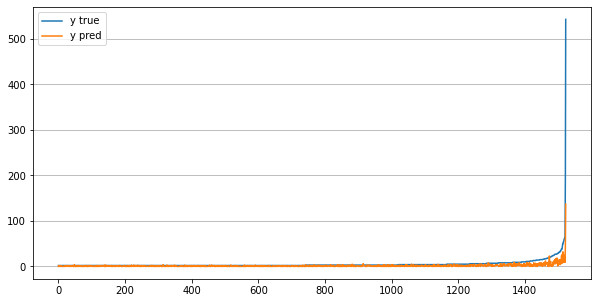

In [ ]:
plot_predictions(y_test_pred, y_test_true)

## Plots

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tb_logs/